In [13]:
%pip install -q open_clip_torch h3 contextily stactools

Note: you may need to restart the kernel to use updated packages.


In [2]:
%%capture
%env AWS_REQUEST_PAYER=requester

---

In [3]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource

from tqdm.auto import tqdm
import numpy as np
import torch
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
INFO:matplotlib.font_manager:generated new fontManager


---

## Load embeddings

In [3]:
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_800_800.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt .

In [4]:
embs_400 = torch.load('data/skyscript_naip_MA_400_400.pt')
# embs_800 = torch.load('skyscript_naip_MA_800_800.pt')
# embs_1600 = torch.load('skyscript_naip_MA_1600_1600.pt')
embs_400.shape,  #embs_800.shape, #embs_1600.shape

(torch.Size([563379, 768]),)

In [101]:
embs_400[100000]

tensor([ 5.7827e-04,  6.1332e-02,  1.0508e-02, -3.8042e-02, -3.3645e-03,
         1.2064e-02, -1.7166e-03,  3.8891e-03, -3.4130e-03,  1.2650e-02,
        -1.1622e-02,  1.3444e-02,  3.2810e-03, -5.9770e-03, -2.5123e-02,
         3.7783e-03,  7.1792e-03, -1.2248e-02,  5.3710e-03, -6.1519e-03,
        -4.5517e-03,  3.4479e-02, -5.4696e-03, -1.2949e-02,  1.2256e-02,
         2.8256e-02,  4.7721e-04, -9.8086e-03, -3.1712e-03, -1.1261e-02,
        -2.8370e-03, -3.4337e-03,  9.6872e-03,  2.2337e-03,  5.4890e-03,
         2.5693e-02,  1.0227e-02, -1.9915e-03, -1.8031e-02,  3.3559e-02,
         1.8125e-03,  2.0457e-03,  4.1632e-03, -3.4160e-02,  2.7799e-02,
         2.7461e-02, -1.8476e-02,  7.7764e-04,  1.7833e-03, -1.5978e-03,
        -8.3589e-04, -1.1469e-02,  8.4552e-03,  1.2670e-02, -2.2528e-02,
        -2.4265e-03,  2.7828e-02, -9.3221e-03, -2.1385e-02, -2.2427e-02,
         1.6499e-02, -4.1310e-02,  6.5018e-03, -2.2726e-03,  1.5520e-02,
         1.1277e-02, -1.3927e-02,  2.3882e-02, -1.4

---

## Load chip windows

In [4]:
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_800_800_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_1600_1600_w_uris.json .

In [5]:
windows_df_400 = gpd.read_file('data/naip_MA_400_400_w_uris.json')
# windows_df_800 = gpd.read_file('naip_MA_800_800_w_uris.json')
# windows_df_1600 = gpd.read_file('naip_MA_1600_1600_w_uris.json')

---

## Load model

In [6]:
import open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

INFO:root:Loaded ViT-L-14 model config.


#params:  427,616,513


In [7]:
ckpt_path = 'data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]: v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.eval()

## Search

In [8]:
uris = set(windows_df_400.uri)
_uri_to_rs = {}

In [9]:
def uri_to_rs(uri: str):
    if uri not in _uri_to_rs:
        _uri_to_rs[uri] = RasterioSource(
            uri, channel_order=[0, 1, 2], allow_streaming=True)
    return _uri_to_rs[uri]

In [10]:
def emb_idx_to_chip(i, windows_df, out_shape=(400, 400)):
    i = int(i)
    uri = windows_df.uri.iloc[i]
    window_geom = windows_df.geometry.iloc[i]
    window = Box.from_shapely(window_geom)
    rs = uri_to_rs(uri)
    chip = rs.get_chip_by_map_window(window, out_shape=out_shape)
    return chip

In [11]:
def show_top_chips(chip_scores,
                   windows_df,
                   top_inds=None,
                   nrows=5,
                   ncols=5,
                   figsize=(12, 12),
                   w_pad=-2.5,
                   h_pad=-2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, i in zip(tqdm(axs.flat), top_inds):
        chip = emb_idx_to_chip(i, windows_df)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()
    return fig

In [12]:
def get_chip_scores(text_queries, embs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


def get_text_emb(text_queries):
    with torch.inference_mode():
        text = tokenizer(text_queries)
        text_emb = model.encode_text(text)
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu()
    return text_emb


def _get_chip_scores(text_emb, image_embs):
    with torch.inference_mode():
        chip_scores = torch.cosine_similarity(text_emb, image_embs)
    return chip_scores

---

# H3

In [14]:
from stactools.core.utils.raster_footprint import densify_by_factor
from shapely.geometry import Polygon

In [15]:
import h3
from matplotlib import patches
import contextily as cx

In [ ]:
rs = next(iter((_uri_to_rs.values())))

In [24]:
rs_bbox = rs.crs_transformer.pixel_to_map(rs.bbox)

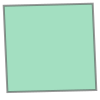

In [87]:
rs_bbox_px = rs.bbox
rs_bbox_geom_dense_px = Polygon(densify_by_factor(rs_bbox_px.to_points(), 4))
rs_bbox_geom_dense_map = rs.crs_transformer.pixel_to_map(rs_bbox_geom_dense_px)

In [111]:
chip_windows = rs.bbox.get_windows(400, 400)
chip_windows = [rs.crs_transformer.pixel_to_map(w) for w in chip_windows]
len(chip_windows)

825

In [106]:
h3_inds = h3.polyfill_polygon(np.array(rs_bbox_geom_dense_map.exterior.coords), res=10)
hexes = [h3.h3_to_geo_boundary(h3_idx) for h3_idx in h3_inds]
len(hexes)

1317

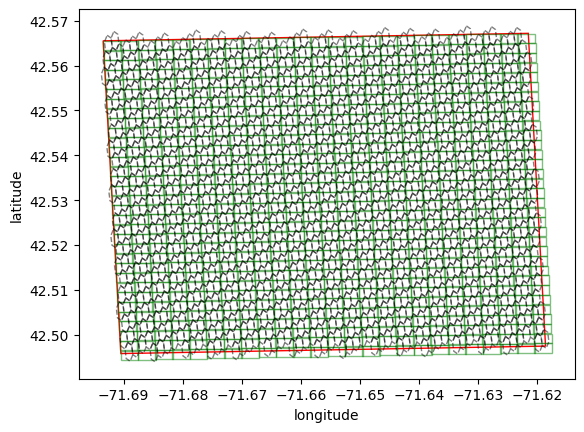

In [112]:
fig, ax = plt.subplots()

rs_bbox_patch = patches.Polygon(
    np.array(rs_bbox_geom_dense_map.exterior.coords), ec='r', fc='none')
ax.add_patch(rs_bbox_patch)

for w in chip_windows:
    w_patch = patches.Polygon(w.to_points(), ec='g', fc='none', alpha=0.5)
    ax.add_patch(w_patch)

for hex in hexes:
    hex_patch = patches.Polygon(hex, ec='k', fc='none', alpha=0.5, ls='--')
    ax.add_patch(hex_patch)
ax.autoscale()

# cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [16]:
df = gpd.read_file('data/us-states.json')
df_aoi = df[df.name == 'Massachusetts']

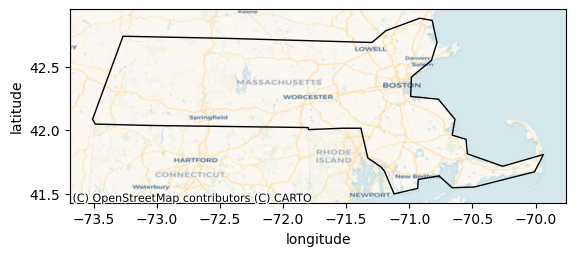

In [17]:
fig, ax = plt.subplots()

df_aoi.plot(ax=ax, ec='k', fc='none')
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [18]:
ma_boundary = np.array(df_aoi.geometry.tolist()[0].exterior.coords)

In [19]:
ma_h3_inds = list(h3.polyfill_polygon(ma_boundary, res=9))
ma_hexes = [h3.h3_to_geo_boundary(h3_idx) for h3_idx in ma_h3_inds]
ma_hexes = [Polygon(h_points) for h_points in ma_hexes]
len(ma_hexes)

83478

In [20]:
h3_df = gpd.GeoDataFrame(dict(h3_index=ma_h3_inds), geometry=ma_hexes)
h3_df

,h3_index,geometry
0,89e720cc9cbffff,"POLYGON ((-71.50408 42.58787, -71.50255 42.584..."
1,89e7250a3b3ffff,"POLYGON ((-72.60847 42.37313, -72.60694 42.369..."
2,89e7250f24bffff,"POLYGON ((-72.60224 42.06326, -72.60069 42.059..."
3,89f05a2822bffff,"POLYGON ((-73.40221 42.17341, -73.40066 42.169..."
4,89e72041bafffff,"POLYGON ((-71.21404 42.10234, -71.21251 42.099..."
...,...,...
83473,89e7205ab4bffff,"POLYGON ((-71.21392 42.59471, -71.2124 42.5914..."
83474,89e720860dbffff,"POLYGON ((-72.06298 42.72324, -72.06146 42.719..."
83475,89e72286acbffff,"POLYGON ((-70.98449 42.19208, -70.98296 42.188..."
83476,89e72055b03ffff,"POLYGON ((-71.36009 42.16254, -71.35856 42.159..."


In [21]:
windows_df_400['geometry_chips'] = windows_df_400['geometry']

In [22]:
%%time
join_df = gpd.sjoin(h3_df, windows_df_400, how='inner')
len(join_df)

CPU times: user 1.35 s, sys: 44.8 ms, total: 1.39 s
Wall time: 1.42 s


1194632

In [23]:
%%time
join_df['ioa'] = join_df['geometry'].intersection(join_df['geometry_chips']).area / join_df['geometry'].area

CPU times: user 12.1 s, sys: 170 ms, total: 12.3 s
Wall time: 12.3 s


In [24]:
tmp_df = join_df[join_df['h3_index'] == '89e72281107ffff']

In [ ]:
tmp_df['geometry'].area

In [ ]:
tmp_df['geometry'].intersection(tmp_df['geometry_chips']).area

In [27]:
tmp_df[['uri', 'ioa']].groupby('uri').agg('sum')

,ioa
uri,
s3://raster-vision-ahassan/naip/2021_MA/42070/m_4207026_nw_19_060_20211024.tif,1.363617


In [29]:
chips = [emb_idx_to_chip(i, windows_df_400) for i in tmp_df['emb_idx']]

INFO:botocore.tokens:Loading cached SSO token for rv


In [30]:
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

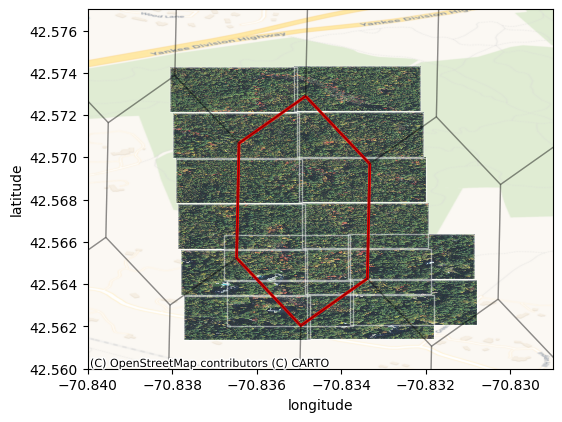

In [88]:
fig, ax = plt.subplots(figsize=(6, 6))

for neighbor_hex in h3.hex_range(tmp_df.iloc[0].h3_index, 2):
    hex_patch = patches.Polygon(h3.h3_to_geo_boundary(neighbor_hex), ec='k', fc='none', alpha=0.25, zorder=3)
    ax.add_patch(hex_patch)

ax.set_xlim((-70.84, -70.829))
ax.set_ylim((42.56, 42.577))

cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)

for w in tmp_df['geometry_chips']:
    w_patch = patches.Polygon(np.array(w.exterior.coords), ec='w', fc='none', alpha=0.5)
    ax.add_patch(w_patch)
for chip, w_geom in zip(chips, tmp_df['geometry_chips']):
    xmin, ymin, xmax, ymax = w_geom.bounds
    bbox = Bbox([(xmin, ymin), (xmax, ymax)])
    bbox = TransformedBbox(bbox, ax.transData)
    ax.add_artist(BboxImage(bbox, data=chip))

tmp_df.iloc[:1].plot(ax=ax, ec='r', fc='none', lw=2)


ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_aspect(0.5)

plt.show()

In [61]:
tmp_df.iloc[:1].bounds

,minx,miny,maxx,maxy
39356,-70.836476,42.562038,-70.833326,42.572893


In [89]:
# embs_merged = torch.empty(len(h3_df), 768)
embs_merged = [None] * len(h3_df)

In [90]:
def agg_embeddings(df):
    hex_embs = embs_400[df['emb_idx'].to_numpy()]
    weighted_hex_embs = hex_embs * df['ioa'].to_numpy()[:, None]
    emb = weighted_hex_embs.sum(dim=0)
    assert df.index[0] == df.index[-1]
    embs_merged[df.index[0]] = emb

In [91]:
join_df.groupby('h3_index').apply(agg_embeddings)

""


In [92]:
unmatched_hex_inds = [i for i, e in enumerate(embs_merged) if e is None]

In [93]:
for i in unmatched_hex_inds:
    embs_merged[i] = torch.zeros(768)

In [94]:
embs_merged = torch.stack(embs_merged)
embs_merged.shape

torch.Size([83478, 768])

In [95]:
def get_hex_scores(text_queries, embs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


In [96]:
def hex_idx_to_chips(i, out_shape=(400, 400)):
    i = int(i)
    h3_index = h3_df.iloc[i]['h3_index']
    chips_df = join_df[join_df['h3_index'] == h3_index]
    chips = []
    window_geoms = []
    with tqdm(chips_df.itertuples(), total=len(chips_df)) as bar:
        for row in bar:
            uri = row.uri
            window_geom = row.geometry_chips
            window = Box.from_shapely(window_geom)
            rs = uri_to_rs(uri)
            chip = rs.get_chip_by_map_window(window, out_shape=out_shape)
            chips.append(chip)
            window_geoms.append(window_geom)
    return chips, window_geoms

In [97]:
def show_top_hexes(hex_scores, k=1):
    plt.close('all')
    top_inds = torch.topk(hex_scores, k).indices.numpy()
    for i in top_inds:
        chips, window_geoms = hex_idx_to_chips(i)
        plot_hex_chips(i, chips, window_geoms)

In [100]:
def plot_hex_chips(hex_idx, chips, window_geoms):
    fig, ax = plt.subplots(figsize=(5, 5))
    hex_geom = h3_df.iloc[hex_idx].geometry
    hex_patch = patches.Polygon(np.array(hex_geom.exterior.coords), ec='r', fc='none', zorder=3)
    ax.add_patch(hex_patch)

    for neighbor_hex in h3.hex_range(h3_df.iloc[hex_idx].h3_index, 2):
        hex_patch = patches.Polygon(h3.h3_to_geo_boundary(neighbor_hex), ec='k', fc='none', alpha=0.25, zorder=3)
        ax.add_patch(hex_patch)

    for chip, w_geom in zip(chips, window_geoms):
        xmin, ymin, xmax, ymax = w_geom.bounds
        bbox = Bbox([(xmin, ymin), (xmax, ymax)])
        bbox = TransformedBbox(bbox, ax.transData)
        ax.add_artist(BboxImage(bbox, data=chip, alpha=1, zorder=1))
        w_patch = patches.Polygon(np.array(w_geom.exterior.coords), ec='w', fc='none', alpha=0.5, zorder=2)
        ax.add_patch(w_patch)

    ax.autoscale()
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, zorder=0)
    ax.set_aspect(0.5)
    plt.show()

  0%|          | 0/19 [00:00<?, ?it/s]

INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv


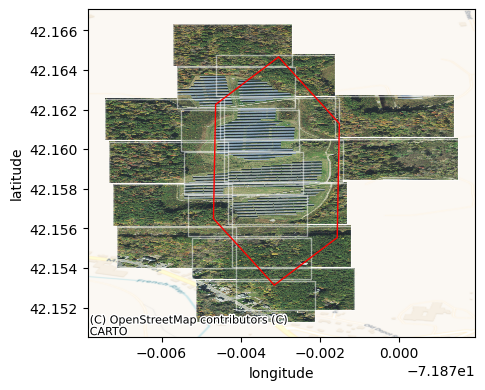

  0%|          | 0/12 [00:00<?, ?it/s]

INFO:botocore.tokens:Loading cached SSO token for rv


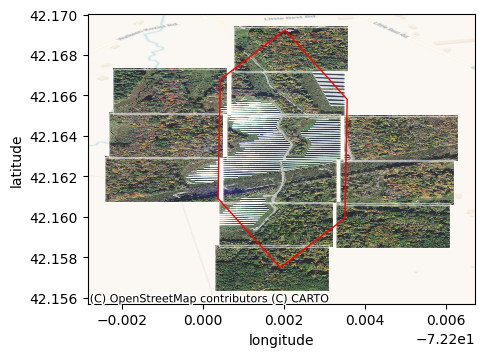

  0%|          | 0/12 [00:00<?, ?it/s]

INFO:botocore.tokens:Loading cached SSO token for rv


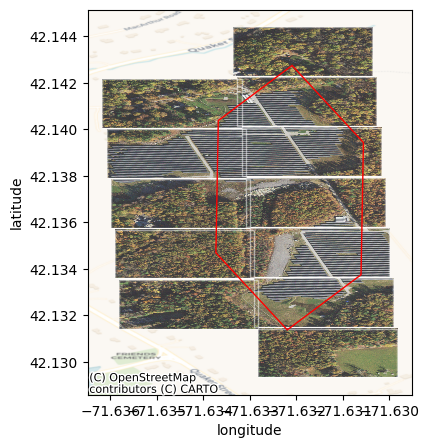

  0%|          | 0/17 [00:00<?, ?it/s]

INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv


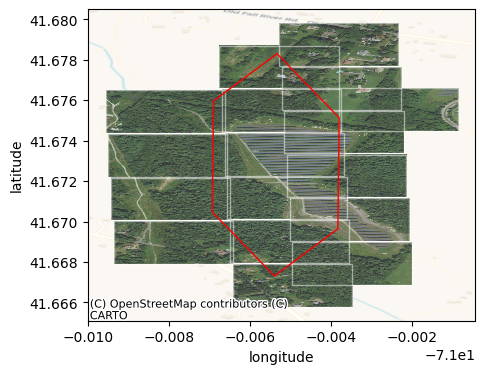

In [99]:
hex_scores = get_hex_scores(['a large solar farm'], embs_merged)
show_top_hexes(hex_scores, 4)